In [1]:
import os
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
import matplotlib as mpl
import pickle as pickle

In [2]:
import prince.config
from prince import core, util, photonfields, cross_sections
from prince import util as pru

CUPY not found for GPU support. Degrading to MKL.


# General Information

This Notebook contains reproductions of results from arXiv:1508.01824  
Specifically these are propagated spectra for different cross sections and photon fields  
**Note:** This notebook contains little documentation, for details see  
`examples/Create_Kernel.ipynb` and `examples/Propagate_single_spectrum.ipynb`

# Setup and save prince_run objects

Setup and save Kernels for different cross sections  
Analogous to `examples/Create_Kernel.ipynb`

In [3]:
%%time
pf = photonfields.CombinedPhotonField(
                [photonfields.CMBPhotonSpectrum, 
                 photonfields.CIBGilmore2D])
cs = cross_sections.CompositeCrossSection([(0., cross_sections.TabulatedCrossSection, ('CRP2_TALYS',)),
                                           (0.14, cross_sections.SophiaSuperposition, ())])
prince_run_talys = core.PriNCeRun(max_mass = 56, photon_field=pf, cross_sections=cs)

CompositeCrossSection::_join_models(): Attempt to join 2 models.
PriNCeRun::__init__(): initialising Energy grid
PhotoNuclearInteractionRate::_init_matrices(): Inclusive interpolator not found for (1105, 1105)
PhotoNuclearInteractionRate::_init_matrices(): Inclusive interpolator not found for (1005, 1005)
PhotoNuclearInteractionRate::_init_matrices(): Inclusive interpolator not found for (1004, 1004)
PhotoNuclearInteractionRate::_init_matrices(): Inclusive interpolator not found for (904, 904)
PhotoNuclearInteractionRate::_init_matrices(): Inclusive interpolator not found for (704, 704)
PhotoNuclearInteractionRate::_init_matrices(): Inclusive interpolator not found for (703, 703)
PhotoNuclearInteractionRate::_init_matrices(): Inclusive interpolator not found for (603, 603)
PhotoNuclearInteractionRate::_init_matrices(): Inclusive interpolator not found for (402, 402)
PhotoNuclearInteractionRate::_init_matrices(): Inclusive interpolator not found for (302, 302)
PhotoNuclearInteractionRat

In [4]:
%%time
pf = photonfields.CombinedPhotonField(
                [photonfields.CMBPhotonSpectrum, 
                 photonfields.CIBGilmore2D])
cs = cross_sections.CompositeCrossSection([(0., cross_sections.TabulatedCrossSection, ('PEANUT_IAS',)),
                                           (0.14, cross_sections.SophiaSuperposition, ())])
prince_run_peanut = core.PriNCeRun(max_mass = 56, photon_field=pf, cross_sections=cs)

CompositeCrossSection::_join_models(): Attempt to join 2 models.
PriNCeRun::__init__(): initialising Energy grid
PhotoNuclearInteractionRate::_init_matrices(): Inclusive interpolator not found for (302, 302)
PhotoNuclearInteractionRate::_init_matrices(): Inclusive interpolator not found for (301, 301)
PhotoNuclearInteractionRate::_init_matrices(): Inclusive interpolator not found for (201, 201)
PhotoNuclearInteractionRate::_init_coupling_mat(): Initiating coupling matrix in (CSR) format
CPU times: user 3min 4s, sys: 7.25 s, total: 3min 11s
Wall time: 2min 53s


# Different cross-sections

### Hard iron

In [5]:
from prince.cr_sources import RigdityCutoffSource

In [6]:
from prince.solvers import UHECRPropagationSolverBDF

In [7]:
source_hard_iron = RigdityCutoffSource(prince_run_talys, params={5626:(1.0, 5e9,  1.0)}, norm=1e-87)

solver_talys = UHECRPropagationSolverBDF(initial_z=1., final_z = 0.,prince_run=prince_run_talys,
                                   enable_pairprod_losses = True, enable_adiabatic_losses = True,
                                   enable_injection_jacobian = True, enable_partial_diff_jacobian=True)
solver_talys.add_source_class(source_hard_iron)
solver_talys.solve(dz=1e-3,verbose=False,full_reset=False,progressbar='notebook')

In [8]:
source_hard_iron = RigdityCutoffSource(prince_run_peanut, params={5626:(1.0, 5e9,  1.0)}, norm=1e-87)

solver_peanut = UHECRPropagationSolverBDF(initial_z=1., final_z = 0.,prince_run=prince_run_peanut,
                                   enable_pairprod_losses = True, enable_adiabatic_losses = True,
                                   enable_injection_jacobian = True, enable_partial_diff_jacobian=True)
solver_peanut.add_source_class(source_hard_iron)
solver_peanut.solve(dz=1e-3,verbose=False,full_reset=False,progressbar='notebook')

/home/jheinze/python_packages/PriNCe/prince/solvers/propagation.py:120: RuntimeWarning: invalid value encountered in log
  np.log(curr_spec),
/home/jheinze/python_packages/PriNCe/prince/solvers/propagation.py:120: RuntimeWarning: invalid value encountered in log
  np.log(curr_spec),
/home/jheinze/python_packages/PriNCe/prince/solvers/propagation.py:120: RuntimeWarning: invalid value encountered in log
  np.log(curr_spec),
/home/jheinze/python_packages/PriNCe/prince/solvers/propagation.py:120: RuntimeWarning: invalid value encountered in log
  np.log(curr_spec),
/home/jheinze/python_packages/PriNCe/prince/solvers/propagation.py:120: RuntimeWarning: invalid value encountered in log
  np.log(curr_spec),
/home/jheinze/python_packages/PriNCe/prince/solvers/propagation.py:120: RuntimeWarning: invalid value encountered in log
  np.log(curr_spec),
/home/jheinze/python_packages/PriNCe/prince/solvers/propagation.py:120: RuntimeWarning: invalid value encountered in log
  np.log(curr_spec),
/home/

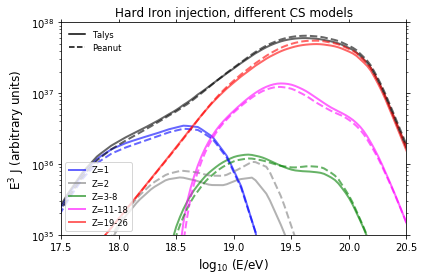

In [9]:
import matplotlib.pyplot as plt

# normalize
result = solver_talys.res
energy, spectrum = result.get_solution_group('CR')
norm = 6e37/np.max(spectrum[(1e10 < energy) & (energy< 1e11)])
alpha = .6

# plot results
for result, ls in zip([solver_talys.res,solver_peanut.res],['solid','dashed']):
    
    ncoid2sref = result.spec_man.ncoid2sref
    Z = lambda el: ncoid2sref[el].Z if el > 100 else 0
    for group, color, label in zip([(Z,1,1),(Z,2,2),(Z,3,10),(Z,11,18),(Z,19,26),'CR'],
                                 ['blue','grey','green','magenta','red','black'],
                                 ['Z=1','Z=2','Z=3-8','Z=11-18','Z=19-26','total']):    
        energy, spectrum = result.get_solution_group(group)
        l = plt.plot(np.log10(1e9*energy), norm* spectrum, ls=ls, lw=2., alpha = alpha, label=label, c=color)

#custom legend
ax = plt.gca()
handles, labels = ax.get_legend_handles_labels()
display = (0,1,2,3,4)

#Create custom artists
legend_talys = plt.Line2D((0,1),(0,0), color='k', linestyle='solid')
legend_peanut = plt.Line2D((0,1),(0,0), color='k', linestyle='dashed')

leg2 =  ax.legend([handle for i,handle in enumerate(handles) if i in display],
           [label for i,label in enumerate(labels) if i in display],
                  ncol = 1, loc = 'lower left', fontsize = 'small')
ax.legend([legend_talys,legend_peanut],['Talys', 'Peanut'], 
          frameon=False, fontsize = 'small')
ax.add_artist(leg2)

plt.semilogy()
# plt.legend(ncol=1, loc='upper left')
plt.tick_params(axis='both',top=True,right=True,which='both')
plt.xlim(17.5,20.5)
plt.ylim(1e35,1e38)
# plt.grid()
plt.ylabel('E$^3$ J (arbitrary units)', fontsize = 'large')
plt.xlabel('log$_{10}$ (E/eV)', fontsize = 'large')
plt.title('Hard Iron injection, different CS models')
plt.tight_layout()

### Hard Nitrogen

In [10]:
source_hard_nitro = RigdityCutoffSource(prince_run_talys, params={1407:(1.0, 5e9,  1.0)}, norm=1e-87)

solver_talys = UHECRPropagationSolverBDF(initial_z=1., final_z = 0.,prince_run=prince_run_talys,
                                   enable_pairprod_losses = True, enable_adiabatic_losses = True,
                                   enable_injection_jacobian = True, enable_partial_diff_jacobian=True)
solver_talys.add_source_class(source_hard_nitro)
solver_talys.solve(dz=1e-3,verbose=False,full_reset=False,progressbar='notebook')

In [11]:
source_hard_nitro = RigdityCutoffSource(prince_run_peanut, params={1407:(1.0, 5e9,  1.0)}, norm=1e-87)

solver_peanut = UHECRPropagationSolverBDF(initial_z=1., final_z = 0.,prince_run=prince_run_peanut,
                                   enable_pairprod_losses = True, enable_adiabatic_losses = True,
                                   enable_injection_jacobian = True, enable_partial_diff_jacobian=True)
solver_peanut.add_source_class(source_hard_nitro)
solver_peanut.solve(dz=1e-3,verbose=False,full_reset=False,progressbar='notebook')

/home/jheinze/python_packages/PriNCe/prince/solvers/propagation.py:120: RuntimeWarning: invalid value encountered in log
  np.log(curr_spec),
/home/jheinze/python_packages/PriNCe/prince/solvers/propagation.py:120: RuntimeWarning: invalid value encountered in log
  np.log(curr_spec),
/home/jheinze/python_packages/PriNCe/prince/solvers/propagation.py:120: RuntimeWarning: invalid value encountered in log
  np.log(curr_spec),
/home/jheinze/python_packages/PriNCe/prince/solvers/propagation.py:120: RuntimeWarning: invalid value encountered in log
  np.log(curr_spec),
/home/jheinze/python_packages/PriNCe/prince/solvers/propagation.py:120: RuntimeWarning: invalid value encountered in log
  np.log(curr_spec),
/home/jheinze/python_packages/PriNCe/prince/solvers/propagation.py:120: RuntimeWarning: invalid value encountered in log
  np.log(curr_spec),
/home/jheinze/python_packages/PriNCe/prince/solvers/propagation.py:120: RuntimeWarning: invalid value encountered in log
  np.log(curr_spec),
/home/

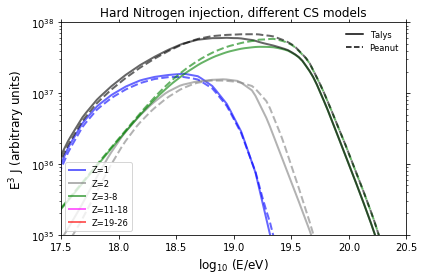

In [12]:
import matplotlib.pyplot as plt

# normalize
result = solver_talys.res
energy, spectrum = result.get_solution_group('CR')
norm = 6e37/np.max(spectrum[(1e10 < energy) & (energy< 1e11)])
alpha = .6

# plot results
for result, ls in zip([solver_talys.res,solver_peanut.res],['solid','dashed']):
    
    ncoid2sref = result.spec_man.ncoid2sref
    Z = lambda el: ncoid2sref[el].Z if el > 100 else 0
    for group, color, label in zip([(Z,1,1),(Z,2,2),(Z,3,10),(Z,11,18),(Z,19,26),'CR'],
                                 ['blue','grey','green','magenta','red','black'],
                                 ['Z=1','Z=2','Z=3-8','Z=11-18','Z=19-26','total']):    
        energy, spectrum = result.get_solution_group(group)
        l = plt.plot(np.log10(1e9*energy), norm* spectrum, ls=ls, lw=2., alpha = alpha, label=label, c=color)

#custom legend
ax = plt.gca()
handles, labels = ax.get_legend_handles_labels()
display = (0,1,2,3,4)

#Create custom artists
legend_talys = plt.Line2D((0,1),(0,0), color='k', linestyle='solid')
legend_peanut = plt.Line2D((0,1),(0,0), color='k', linestyle='dashed')

leg2 =  ax.legend([handle for i,handle in enumerate(handles) if i in display],
           [label for i,label in enumerate(labels) if i in display],
                  ncol = 1, loc = 'lower left', fontsize = 'small')
ax.legend([legend_talys,legend_peanut],['Talys', 'Peanut'], 
          frameon=False, fontsize = 'small')
ax.add_artist(leg2)


plt.semilogy()
# plt.legend(ncol=1, loc='upper left')
plt.tick_params(axis='both',top=True,right=True,which='both')
plt.xlim(17.5,20.5)
plt.ylim(1e35,1e38)
# plt.grid()
plt.ylabel('E$^3$ J (arbitrary units)', fontsize = 'large')
plt.xlabel('log$_{10}$ (E/eV)', fontsize = 'large')
plt.title('Hard Nitrogen injection, different CS models')
plt.tight_layout()